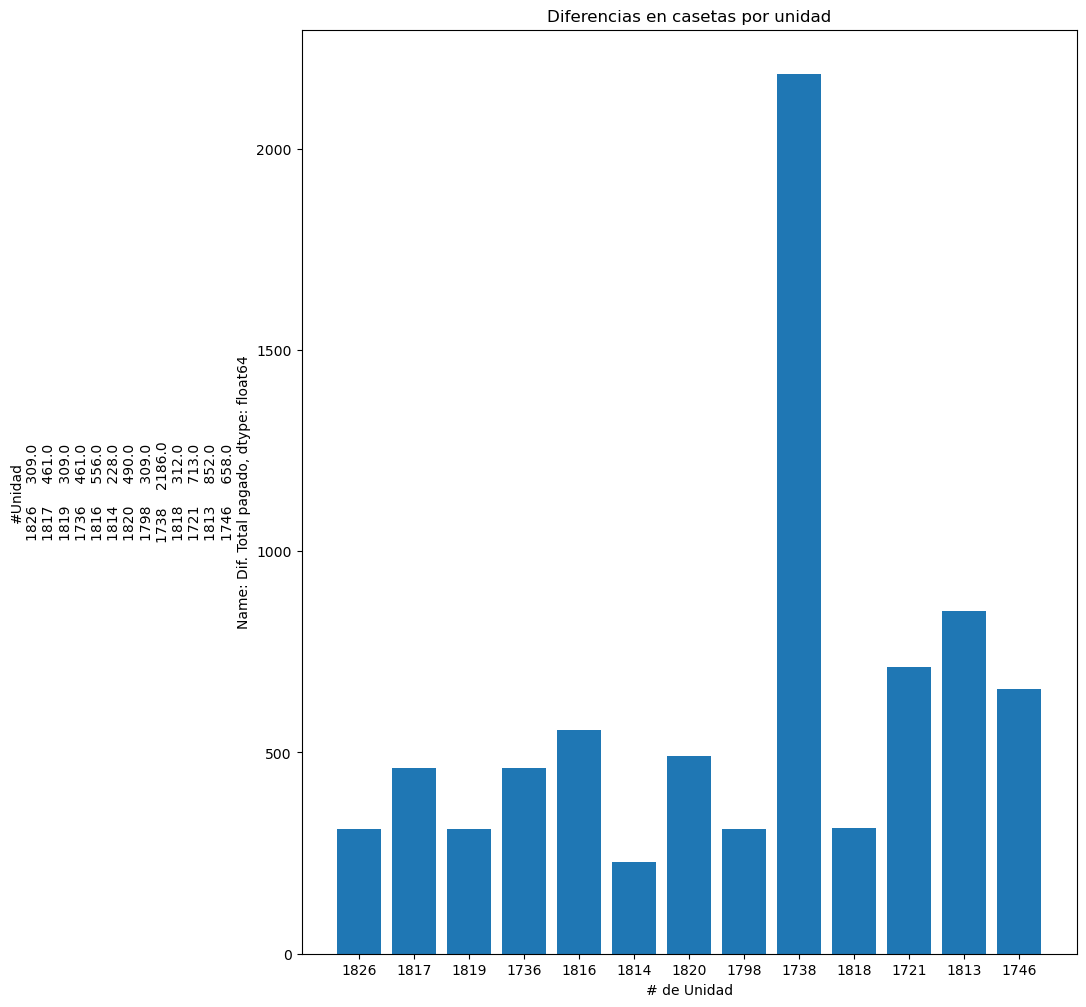

In [5]:
from dash import Dash, html, dcc, Input, Output  # pip install dash
import dash_bootstrap_components as dbc
from vega_datasets import data             # pip install vega-datasets
import pandas as pd
import numpy as np

import altair as alt                        # pip install altair

import matplotlib.pyplot as plt             # pip install matplotlib
import mpld3                                # pip install mpld3

from bokeh.plotting import figure           # pip install Bokeh
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.models import ColumnDataSource

# bring data into app
casetas = pd.read_excel('Casetas TDR.xlsx')
tlvia = pd.read_excel('Compilado televía 2.xlsx')
# print(cars.columns)

tlcount = tlvia[['TAG', 'Importe']].groupby('TAG').count()
cascount = casetas[['TAG', 'Costo Caseta']].groupby('TAG').count()
tlsum = tlvia[['TAG', 'Importe']].groupby('TAG').sum()
cassum = casetas[['TAG', 'Costo Caseta']].groupby('TAG').sum()
diffcount =  pd.DataFrame(tlcount['Importe'] - cascount['Costo Caseta'])
diffsum = pd.DataFrame(tlsum['Importe'] - cassum['Costo Caseta'])
diffsum = diffsum[diffsum != 0]
diffcount = diffcount[diffcount != 0]
diff = pd.merge(diffcount, diffsum, left_index=True, right_index=True)
diff.rename(columns = {'0_x':'Dif. Casetas pagadas', '0_y':'Dif. Total pagado'}, inplace = True)
tlvia.set_index('TAG', inplace=True)
diff2 = pd.merge(diff, tlvia, left_index=True, right_index=True)
diff2 = diff2[['#Unidad', 'Dif. Casetas pagadas', 'Dif. Total pagado']].dropna()
diff2.drop_duplicates(inplace=True)
diff2['#Unidad'] = diff2['#Unidad'].astype(str)
diff2.set_index('#Unidad', inplace=True)

User Selected this dropdown value: Dif. Total pagado


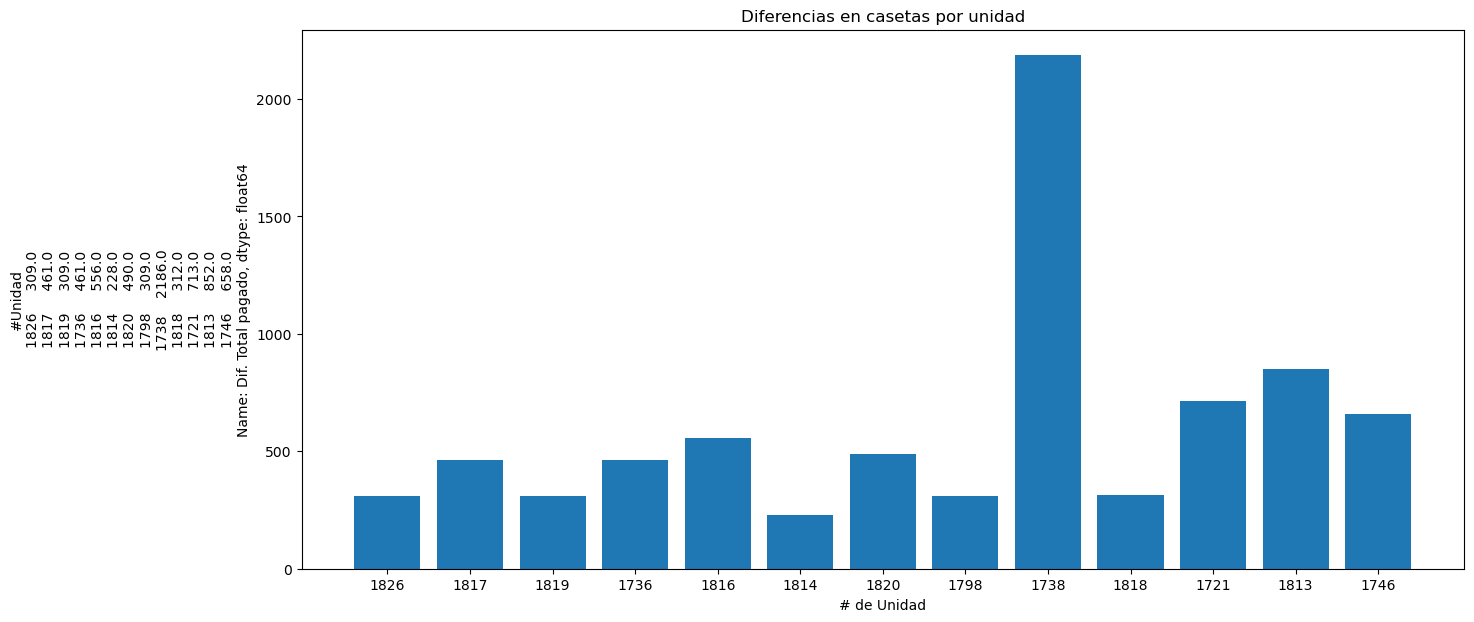

User Selected this dropdown value: Dif. Total pagado


In [7]:
# Set up Dash app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Set up the page layout
app.layout = dbc.Container([
    html.H1("Diferencias casetas por unidad"),

    html.Iframe(
        id='Barras',
        srcDoc=None, # here is where we will put the graph we make
        style={'border-width': '5', 'width': '100%', 'height': '500px'}),

    html.H5("Selecciona columna y", className='mt-2'),
    dcc.Dropdown(
        id='mydropdown',
        value='Dif. Total pagado',
        options=[{'label': col, 'value': col} for col in diff2.columns])
])

@app.callback(
    Output(component_id='Barras', component_property='srcDoc'),
    Input(component_id='mydropdown', component_property='value'))

def plot_data(selected_ycol):
    print(f"User Selected this dropdown value: {selected_ycol}")
    
# Matplotlib graphing library------------------------------------------
    colvalue = diff2[selected_ycol]
    fig, ax = plt.subplots(figsize=(18,5))
    ax.bar(diff2.index.values, colvalue) # variable categorica, variable numerica
    ax.set_title('Diferencias en casetas por unidad')
    ax.set_ylabel(colvalue)
    ax.set_xlabel('# de Unidad')
    html_matplotlib = mpld3.fig_to_html(fig)
    return html_matplotlib


if __name__ == '__main__':
    app.run_server(debug=True, port='8004')